In [1]:
import numpy as np

# Physical parameters
mtot = 0.943
m_motor = 0.052
m_prop  = 0.01
mr = m_motor + m_prop
md = mtot - 4*(m_motor + m_prop)
L = 0.225   # arm length
I_single = (m_motor + m_prop) * L**2

h1 = 1
g = 9.81
rho = 1.225

k_drag = 1e-6

Ixx = 2 * I_single
Iyy = 2 * I_single
Izz = 4 * I_single

omega_hover = 400
k_thrust = mtot * g / (4 * omega_hover**2)

params = {
    "mtot": mtot, "md": md, "mr": mr,
    "I": I_single, "h1": h1, "g": g, "rho": rho,
    "L": L, "omega_hover": omega_hover,
    "k_thrust": k_thrust, "k_drag": k_drag,
    "Ixx": Ixx, "Iyy": Iyy, "Izz": Izz
}


In [2]:
def rotation(phi, theta, psi):
    cphi, sphi = np.cos(phi), np.sin(phi)
    cth,  sth  = np.cos(theta), np.sin(theta)
    cpsi, spsi = np.cos(psi), np.sin(psi)

    return np.array([
        [cpsi*cth,  spsi*cth,   -sth],
        [cpsi*sth*sphi - spsi*cphi,   spsi*sth*sphi + cpsi*cphi,   cth*sphi],
        [cpsi*sth*cphi + spsi*sphi,   spsi*sth*cphi - cpsi*sphi,   cth*cphi]
    ])


In [3]:
def euler_rates(phi, theta, psi, p, q, r):
    phi_dot   = p + q*np.sin(phi)*np.tan(theta) + r*np.cos(phi)*np.tan(theta)
    theta_dot =     q*np.cos(phi)               - r*np.sin(phi)
    psi_dot   =     q*np.sin(phi)/np.cos(theta) + r*np.cos(phi)/np.cos(theta)
    return np.array([phi_dot, theta_dot, psi_dot])


In [4]:
def thrust_body(omegas):
    kT = params["k_thrust"]
    return np.array([0, 0, kT * np.sum(omegas**2)])

def torque_body(omegas):
    L = params["L"]
    kT = params["k_thrust"]
    b = params["k_drag"]

    w1, w2, w3, w4 = omegas
    tau_phi   = L * kT * (w1**2 - w3**2)
    tau_theta = L * kT * (w2**2 - w4**2)
    tau_psi   = b * (w1**2 - w2**2 + w3**2 - w4**2)

    return np.array([tau_phi, tau_theta, tau_psi])


In [5]:
def total_thrust(omegas, params=params):
    kT = params["k_thrust"]
    return kT * np.sum(omegas**2)

def acceleration(omegas, angles, xdot, params):
    m = params["mtot"]
    g = params["g"]

    phi, theta, psi = angles
    R = rotation(phi, theta, psi)

    # correct total thrust magnitude
    T = total_thrust(omegas, params)

    # thrust direction = body z mapped to world
    T_I = R @ np.array([0, 0, T])

    gravity = np.array([0, 0, -g])

    return gravity + T_I/m


def angular_acceleration(omega_sq, omega, params):
    p, q, r = omega
    Ixx, Iyy, Izz = params["Ixx"], params["Iyy"], params["Izz"]

    tau = torque_body(omega_sq)
    tau_phi, tau_theta, tau_psi = tau

    p_dot = (tau_phi   / Ixx) - ((Iyy - Izz)/Ixx) * q * r
    q_dot = (tau_theta / Iyy) - ((Izz - Ixx)/Iyy) * p * r
    r_dot = (tau_psi   / Izz) - ((Ixx - Iyy)/Izz) * p * q

    return np.array([p_dot, q_dot, r_dot])


In [6]:
dt = 0.005
start_time = 0
end_time = 120  # or however long you want
times = np.arange(start_time, end_time, dt)

# State storage
Xs = []
Vels = []
Angles = []
Omegas = []

# Initial conditions
x = np.array([0., 0., 0.])
xdot = np.zeros(3)
angles = np.zeros(3)
omega = np.zeros(3)    # NO random disturbance

def input_func(t):
    return np.array([400, 400, 400, 400])  # constant hover

for t in times:
    omegas = input_func(t)

    a = acceleration(omegas, angles, xdot, params)
    omegadot = angular_acceleration(omegas, omega, params)

    omega += dt * omegadot
    angles += dt * euler_rates(*angles, *omega)
    xdot += dt * a
    x += dt * xdot

    # store
    Xs.append(x.copy())
    Vels.append(xdot.copy())
    Angles.append(angles.copy())
    Omegas.append(omega.copy())

Xs = np.array(Xs)
Angles = np.array(Angles)
Omegas = np.array(Omegas)


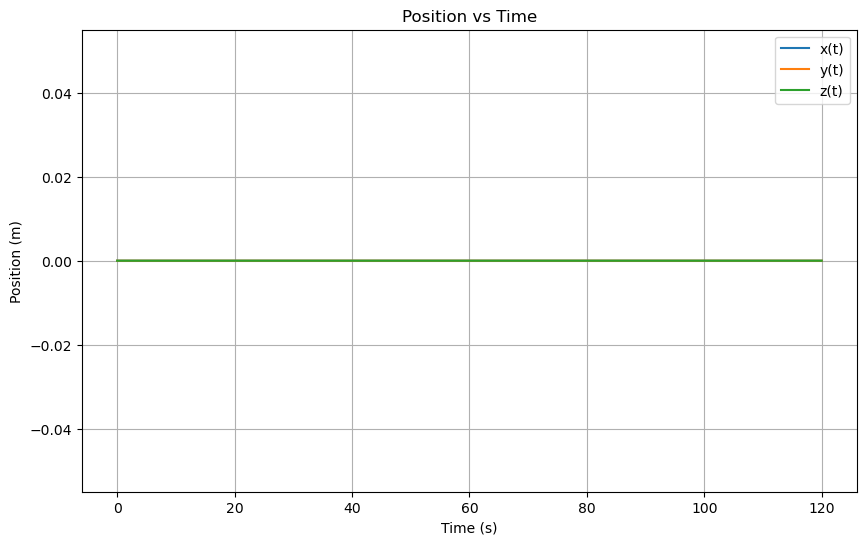

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(times, Xs[:,0], label="x(t)")
plt.plot(times, Xs[:,1], label="y(t)")
plt.plot(times, Xs[:,2], label="z(t)")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.title("Position vs Time")
plt.legend()
plt.grid(True)
plt.show()


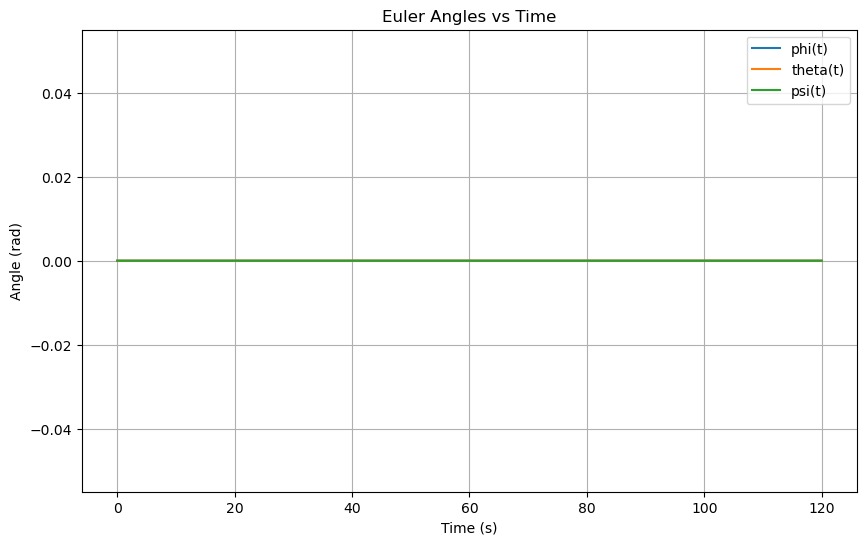

In [8]:
plt.figure(figsize=(10,6))
plt.plot(times, Angles[:,0], label="phi(t)")
plt.plot(times, Angles[:,1], label="theta(t)")
plt.plot(times, Angles[:,2], label="psi(t)")
plt.xlabel("Time (s)")
plt.ylabel("Angle (rad)")
plt.title("Euler Angles vs Time")
plt.legend()
plt.grid(True)
plt.show()


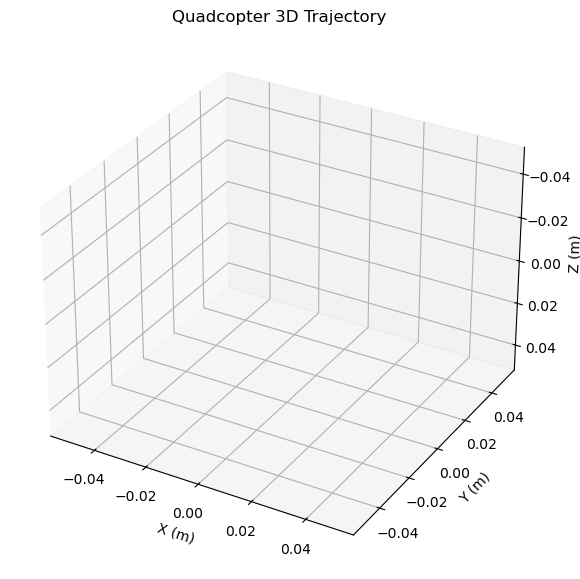

In [9]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(Xs[:,0], Xs[:,1], Xs[:,2], linewidth=2)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('Quadcopter 3D Trajectory')
ax.invert_zaxis()
plt.show()


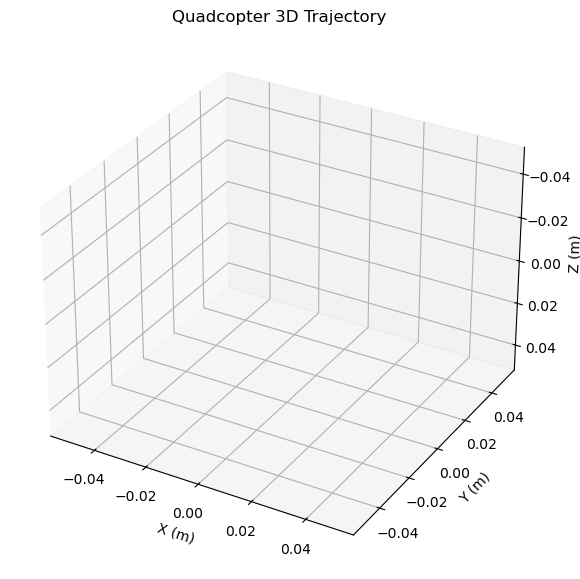

In [10]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(Xs[:,0], Xs[:,1], Xs[:,2], linewidth=2)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('Quadcopter 3D Trajectory')
ax.invert_zaxis()  # optional: make height go up visually
plt.show()


In [11]:
def hover_input(t):
    """
    Constant rotor speeds equal to hover rpm.
    From: 4 * k_thrust * omega_hover^2 = m g
    """
    omega_h = params["omega_hover"]
    return np.array([omega_h, omega_h, omega_h, omega_h])


In [12]:
def simulate_hover(T=120.0, dt=0.005):
    """
    Simulate hover for duration T (seconds) with timestep dt.
    Returns:
      times, Xs, Angles, Omegas_body
    """
    times = np.arange(0.0, T+dt, dt)

    # Initial state: hover 1 m above ground
    x      = np.array([0.0, 0.0, 1.0])    # <-- REQUIRED
    xdot   = np.zeros(3)                  # linear velocity
    angles = np.zeros(3)                  # phi, theta, psi
    omega_body = np.zeros(3)              # p, q, r (body rates)

    # Storage
    N = len(times)
    Xs = np.zeros((N, 3))
    Angles_arr = np.zeros((N, 3))
    Omegas_arr = np.zeros((N, 3))

    for i, t in enumerate(times):

        # constant hover rotor speeds
        omegas = hover_input(t)

        # accelerations
        a = acceleration(omegas, angles, xdot, params)
        omegadot = angular_acceleration(omegas, omega_body, params)

        # integrate rotational motion
        omega_body = omega_body + dt * omegadot
        angles     = angles + dt * euler_rates(*angles, *omega_body)

        # integrate linear motion
        xdot = xdot + dt * a
        x    = x    + dt * xdot

        # log data
        Xs[i,:] = x
        Angles_arr[i,:] = angles
        Omegas_arr[i,:] = omega_body

    return times, Xs, Angles_arr, Omegas_arr


In [13]:
# --- Run Hover Simulation ---
T_hover = 120.0     # 2 minutes
dt       = 0.005

times, Xs_hov, Angles_hov, Omegas_hov = simulate_hover(T=T_hover, dt=dt)


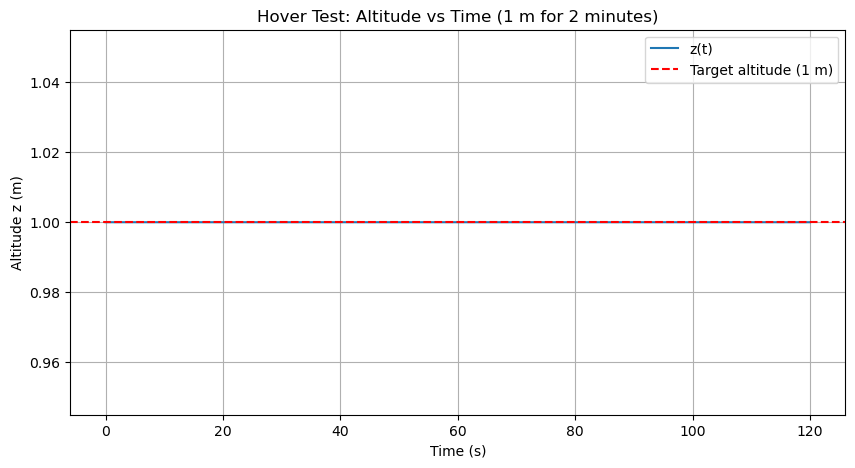

In [14]:
plt.figure(figsize=(10,5))
plt.plot(times, Xs_hov[:,2], label="z(t)")
plt.axhline(1.0, color='r', linestyle='--', label="Target altitude (1 m)")
plt.xlabel("Time (s)")
plt.ylabel("Altitude z (m)")
plt.title("Hover Test: Altitude vs Time (1 m for 2 minutes)")
plt.grid(True)
plt.legend()
plt.show()


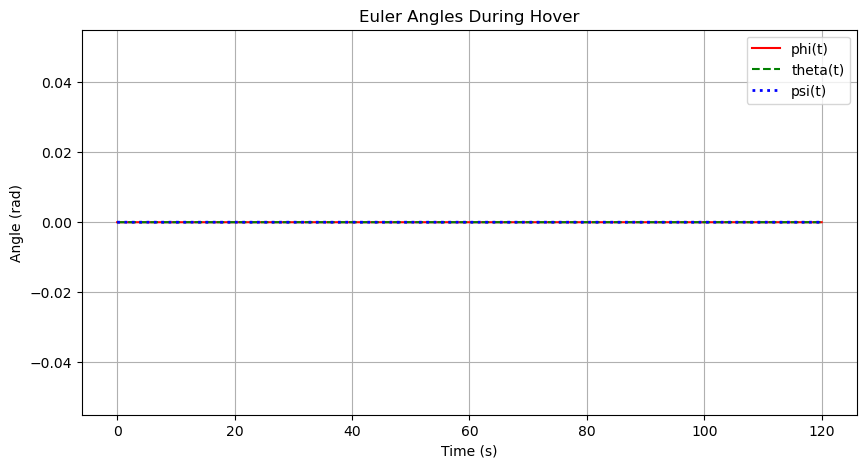

In [15]:
plt.figure(figsize=(10,5))
plt.plot(times, Angles_hov[:,0], 'r-',  linewidth=1.5, label='phi(t)')
plt.plot(times, Angles_hov[:,1], 'g--', linewidth=1.5, label='theta(t)')
plt.plot(times, Angles_hov[:,2], 'b:',  linewidth=2.0, label='psi(t)')

plt.xlabel("Time (s)")
plt.ylabel("Angle (rad)")
plt.title("Euler Angles During Hover")
plt.grid(True)
plt.legend()
plt.show()


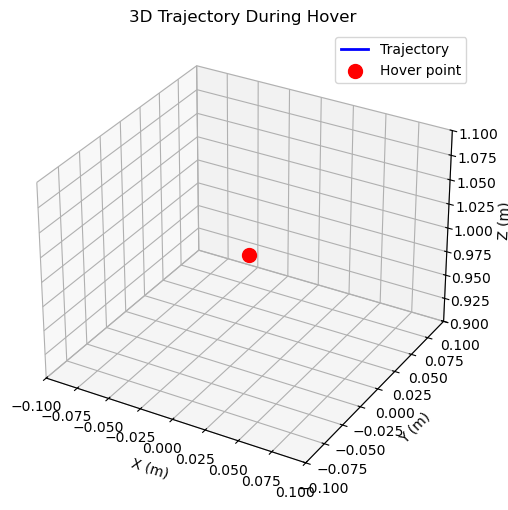

In [16]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# Plot the trajectory (basically a tiny cloud)
ax.plot(Xs_hov[:,0], Xs_hov[:,1], Xs_hov[:,2], 
        color='blue', linewidth=2, label="Trajectory")

# Plot the hover point as a big marker
ax.scatter(Xs_hov[-1,0], Xs_hov[-1,1], Xs_hov[-1,2],
           color='red', s=100, label="Hover point")

ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_zlabel("Z (m)")
ax.set_title("3D Trajectory During Hover")

# Make axes "equal scale" so it's visible
max_range = 0.1
ax.set_xlim(-max_range, max_range)
ax.set_ylim(-max_range, max_range)
ax.set_zlim(1 - max_range, 1 + max_range)

ax.legend()
plt.show()


In [17]:
def motor_speeds_from_thrust_torques(T, tau_phi, tau_theta, tau_psi, params=params):
    """
    Given desired total thrust T and body torques (tau_phi, tau_theta, tau_psi),
    solve for the rotor speeds [ω1, ω2, ω3, ω4].

    Returns ω's in rad/s.
    """
    kT = params["k_thrust"]
    L  = params["L"]
    b  = params["k_drag"]

    A = np.array([
        [ kT,      kT,      kT,      kT     ],
        [ L*kT,    0.0,    -L*kT,    0.0    ],
        [ 0.0,     L*kT,    0.0,    -L*kT   ],
        [ b,      -b,       b,      -b      ]
    ])

    u = np.array([T, tau_phi, tau_theta, tau_psi])

    # solve A * [ω1², ω2², ω3², ω4²] = u
    omega_sq = np.linalg.solve(A, u)

    # numerical safety: no negative due to tiny floating noise
    omega_sq = np.clip(omega_sq, 0.0, None)

    return np.sqrt(omega_sq)


In [18]:
def simulate_circle(T=60.0, dt=0.01):
    R_path = 2.0
    v = 0.5
    Omega = v / R_path  # angular rate

    m = params["mtot"]
    g = params["g"]

    # Position control gains
    kP_xy = 2.0
    kD_xy = 1.2

    # Altitude (z) gains (now PI-D)
    kP_z = 8.0
    kD_z = 4.0
    kI_z = 2.0      # NEW: integral gain (keep modest)


    # Attitude gains
    kP_att = 6.0
    kD_att = 1.5

    # Yaw gains
    kP_yaw = 4.0
    kD_yaw = 0.8

    times = np.arange(0, T, dt)

    # Initial state
    x     = np.array([R_path, 0.0, 1.0])
    xdot  = np.zeros(3)
    angles = np.zeros(3)        # [phi, theta, psi]
    omega_body = np.zeros(3)    # [p, q, r]

    Xs = np.zeros((len(times),3))
    Angles_log = np.zeros((len(times),3))
    z_int = 0.0     # integral of altitude error

    for i, t in enumerate(times):
        phi, theta, psi = angles
        p, q, r = omega_body

        # ---------- Desired circle trajectory ----------
        x_d = np.array([
            R_path * np.cos(Omega*t),
            R_path * np.sin(Omega*t),
            1.0                      # desired altitude
        ])

        xdot_d = np.array([
            -R_path * Omega * np.sin(Omega*t),
             R_path * Omega * np.cos(Omega*t),
             0.0
        ])

        # ---------- Position errors ----------
        e_pos = x_d - x
        e_vel = xdot_d - xdot

        # lateral desired accelerations (x,y only)
        a_des_xy = kP_xy * e_pos[:2] + kD_xy * e_vel[:2]
        a_des_x, a_des_y = a_des_xy

        # ---------- Altitude control (PI-D) ----------
        z_ref = 1.0
        e_z    = z_ref - x[2]
        e_zdot = 0.0 - xdot[2]

        # integrate altitude error
        z_int += e_z * dt
        # simple anti-windup clamp
        z_int = np.clip(z_int, -2.0, 2.0)

        # total thrust with tilt compensation
        T_raw = m * g + kP_z * e_z + kD_z * e_zdot + kI_z * z_int
        T_des = T_raw / (np.cos(phi)*np.cos(theta) + 1e-6)


        # ---------- Desired attitude from lateral accel ----------
        # a_x = g * (-theta), a_y = g * phi  (small-angle approx)
        phi_des   =  a_des_y / g
        theta_des = -a_des_x / g
        psi_des   = Omega * t

        # ---------- Attitude PD -> torques ----------
        tau_phi   = kP_att*(phi_des   - phi)   - kD_att*p
        tau_theta = kP_att*(theta_des - theta) - kD_att*q
        tau_psi   = kP_yaw*(psi_des   - psi)   - kD_yaw*r

        # ---------- Mixer: [T_des, τϕ, τθ, τψ] -> rotor speeds ----------
        omegas = motor_speeds_from_thrust_torques(T_des, tau_phi, tau_theta, tau_psi)

        # ---------- Dynamics update ----------
        a        = acceleration(omegas, angles, xdot, params)
        omegadot = angular_acceleration(omegas, omega_body, params)

        omega_body += dt * omegadot
        angles     += dt * euler_rates(*angles, *omega_body)
        xdot       += dt * a
        x          += dt * xdot

        Xs[i]         = x
        Angles_log[i] = angles

    return times, Xs, Angles_log

times_circ, Xs_circ, Angles_circ = simulate_circle()


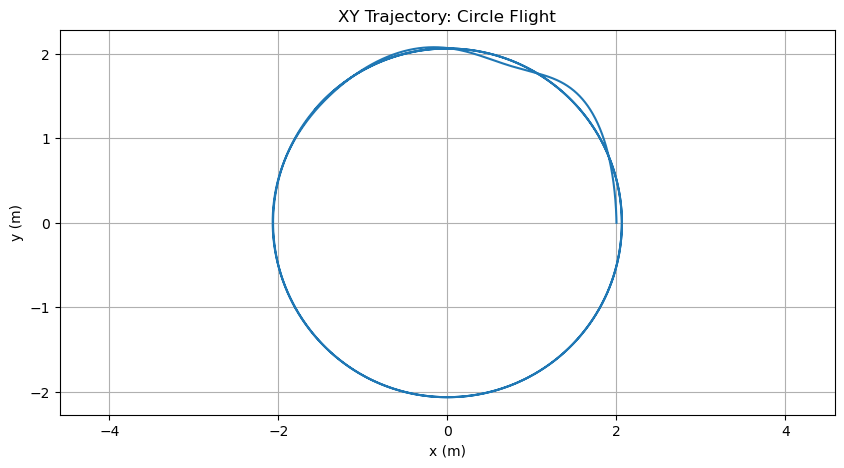

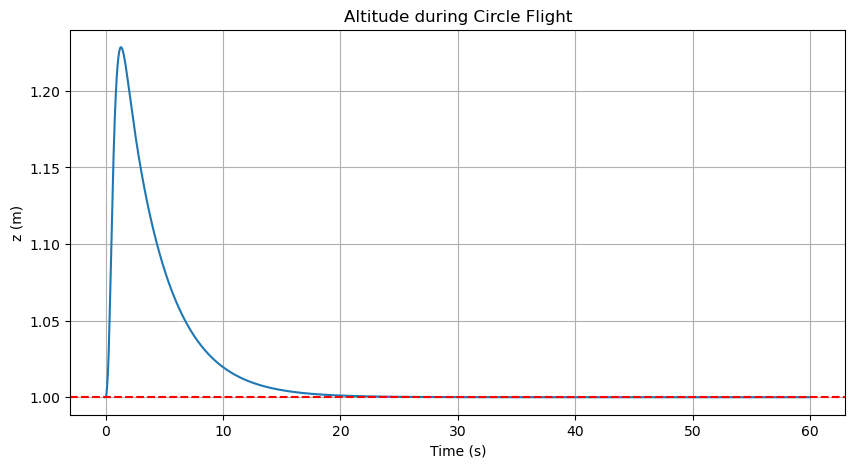

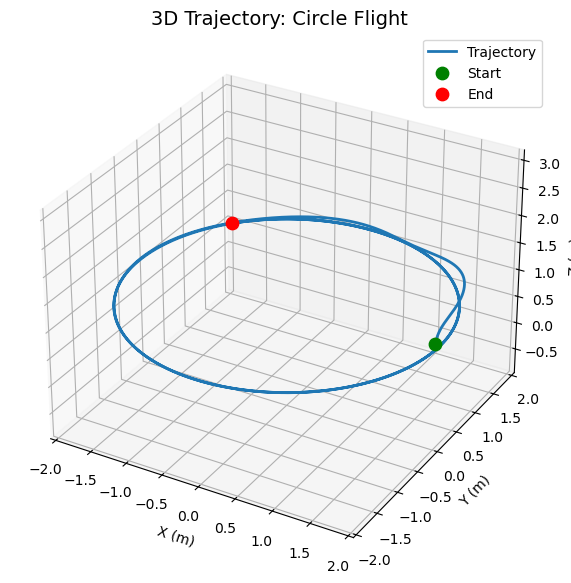

In [22]:
plt.figure(figsize=(10,5))
plt.plot(Xs_circ[:,0], Xs_circ[:,1])
plt.axis('equal')
plt.title("XY Trajectory: Circle Flight")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(times_circ, Xs_circ[:,2])
plt.axhline(1.0, color='red', linestyle='--')
plt.title("Altitude during Circle Flight")
plt.xlabel("Time (s)")
plt.ylabel("z (m)")
plt.grid(True)
plt.show()

# --- 3D Trajectory Plot for Circle Flight ---
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')

# Extract coordinates
X = Xs_circ[:,0]
Y = Xs_circ[:,1]
Z = Xs_circ[:,2]

ax.plot(X, Y, Z, linewidth=2, label='Trajectory')

# Mark start & end
ax.scatter(X[0], Y[0], Z[0], color='green', s=80, label='Start')
ax.scatter(X[-1], Y[-1], Z[-1], color='red', s=80, label='End')

# Labeling
ax.set_title("3D Trajectory: Circle Flight", fontsize=14)
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_zlabel("Z (m)")

# Keep aspect ratio reasonable
max_range = np.max([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]) / 2.0
mid_x     = (X.max()+X.min()) * 0.5
mid_y     = (Y.max()+Y.min()) * 0.5
mid_z     = (Z.max()+Z.min()) * 0.5

ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

ax.legend()
ax.grid(True)

plt.show()



In [25]:
# %%  PERFORMANCE GOAL 3: box trajectory with takeoff and landing

def simulate_mission3(dt=0.01):
    """
    Mission:
      1) Takeoff from z=0 to z=1 m.
      2) Fly straight 5 m at ~1 m/s at z=1 m (heading ψ = 0).
      3) Hover.
      4) Yaw left 90 deg.
      5) Fly another straight 5 m at z=1 m.
      6) Hover.
      7) Land to z=0 with small vertical speed.
    """

    # ---------- Phase durations ----------
    T_to     = 3.0   # takeoff
    T_leg    = 5.0   # each 5 m leg at ~1 m/s
    T_hover1 = 3.0
    T_yaw    = 2.0
    T_hover2 = 3.0
    T_land   = 20.0  # slow-ish landing

    t0_to     = 0.0
    t0_leg1   = t0_to   + T_to
    t0_hover1 = t0_leg1 + T_leg
    t0_yaw    = t0_hover1 + T_hover1
    t0_leg2   = t0_yaw  + T_yaw
    t0_hover2 = t0_leg2 + T_leg
    t0_land   = t0_hover2 + T_hover2
    T_total   = t0_land + T_land

    times = np.arange(0.0, T_total, dt)

    # ---------- Controller gains ----------
    m = params["mtot"]
    g = params["g"]

    # altitude PI-D (same idea as circle case)
    kP_z = 8.0
    kD_z = 4.0
    kI_z = 2.0

    # position -> attitude (outer loop)
    kP_x = 1.0
    kD_x = 1.0
    kP_y = 1.0
    kD_y = 1.0

    # attitude (inner loop)
    kP_att = 8.0
    kD_att = 2.0

    # yaw control
    kP_yaw = 5.0
    kD_yaw = 1.0

    max_angle = np.deg2rad(20.0)  # saturate desired φ,θ

    # ---------- State initialization ----------
    x      = np.array([0.0, 0.0, 0.0])   # start on ground
    xdot   = np.zeros(3)
    angles = np.zeros(3)                 # [phi, theta, psi]
    omega  = np.zeros(3)                 # [p, q, r]

    # integral of altitude error
    z_int = 0.0

    # storage
    N = len(times)
    Xs      = np.zeros((N, 3))
    Vels    = np.zeros((N, 3))
    Angles  = np.zeros((N, 3))
    Omegas  = np.zeros((N, 3))

    # ---------- Helper: reference generator ----------
    def mission_refs(t):
        # defaults
        x_ref  = 0.0
        y_ref  = 0.0
        z_ref  = 0.0
        psi_ref = 0.0

        # 1) Takeoff: 0->1 m
        if t < t0_leg1:
            tau = (t - t0_to) / T_to
            tau = np.clip(tau, 0.0, 1.0)
            z_ref = tau * 1.0
            x_ref, y_ref = 0.0, 0.0
            psi_ref = 0.0

        # 2) First straight leg: x 0->5 m
        elif t < t0_hover1:
            tau = (t - t0_leg1) / T_leg
            tau = np.clip(tau, 0.0, 1.0)
            x_ref = 5.0 * tau
            y_ref = 0.0
            z_ref = 1.0
            psi_ref = 0.0

        # 3) Hover at (5,0,1)
        elif t < t0_yaw:
            x_ref, y_ref, z_ref = 5.0, 0.0, 1.0
            psi_ref = 0.0

        # 4) Yaw 0 -> +90 deg (left turn)
        elif t < t0_leg2:
            tau = (t - t0_yaw) / T_yaw
            tau = np.clip(tau, 0.0, 1.0)
            x_ref, y_ref, z_ref = 5.0, 0.0, 1.0
            psi_ref = tau * (np.pi/2.0)

        # 5) Second straight leg: y 0->5 m in inertial frame
        elif t < t0_hover2:
            tau = (t - t0_leg2) / T_leg
            tau = np.clip(tau, 0.0, 1.0)
            x_ref = 5.0
            y_ref = 5.0 * tau
            z_ref = 1.0
            psi_ref = np.pi/2.0

        # 6) Hover at (5,5,1), heading 90 deg
        elif t < t0_land:
            x_ref, y_ref, z_ref = 5.0, 5.0, 1.0
            psi_ref = np.pi/2.0

        # 7) Landing: z 1 -> 0 with smooth profile
        else:
            tau = (t - t0_land) / T_land
            tau = np.clip(tau, 0.0, 1.0)
            # cosine ramp: dz/dt = 0 at start and end
            z_ref = 0.5 * (1.0 + np.cos(np.pi * tau))
            x_ref, y_ref = 5.0, 5.0
            psi_ref = np.pi/2.0

        return x_ref, y_ref, z_ref, psi_ref

    # ---------- Main simulation loop ----------
    for i, t in enumerate(times):
        phi, theta, psi = angles
        vx, vy, vz = xdot
        p, q, r = omega

        # references from mission profile
        x_ref, y_ref, z_ref, psi_ref = mission_refs(t)

        # ----- Position control -> desired attitudes -----
        ex = x_ref - x[0]
        ey = y_ref - x[1]

        theta_des = kP_x*ex - kD_x*vx     # pitch controls x
        phi_des   = -(kP_y*ey - kD_y*vy)  # roll controls y (sign chosen so +ey -> +phi)

        # limit commanded angles
        phi_des   = np.clip(phi_des,   -max_angle, max_angle)
        theta_des = np.clip(theta_des, -max_angle, max_angle)

        # ----- Altitude PI-D -----
        e_z    = z_ref - x[2]
        e_zdot = 0.0 - vz

        z_int += e_z * dt
        z_int = np.clip(z_int, -2.0, 2.0)

        T_raw = m*g + kP_z*e_z + kD_z*e_zdot + kI_z*z_int
        T_des = T_raw / (np.cos(phi)*np.cos(theta) + 1e-6)

        # ----- Attitude / yaw PD -> torques -----
        e_phi   = phi_des   - phi
        e_theta = theta_des - theta

        # wrap yaw error to [-π, π] to avoid big jumps
        e_psi = psi_ref - psi
        e_psi = (e_psi + np.pi) % (2*np.pi) - np.pi

        tau_phi   = kP_att*e_phi   - kD_att*p
        tau_theta = kP_att*e_theta - kD_att*q
        tau_psi   = kP_yaw*e_psi   - kD_yaw*r

        # map thrust + torques -> rotor speeds
        omegas = motor_speeds_from_thrust_torques(T_des, tau_phi, tau_theta, tau_psi)

        # dynamics
        a        = acceleration(omegas, angles, xdot, params)
        omegadot = angular_acceleration(omegas, omega, params)

        # integrate
        omega  += dt * omegadot
        angles += dt * euler_rates(*angles, *omega)
        xdot   += dt * a
        x      += dt * xdot

        # log
        Xs[i]     = x
        Vels[i]   = xdot
        Angles[i] = angles
        Omegas[i] = omega

    return times, Xs, Vels, Angles, Omegas

# Run mission 3
times_m3, Xs_m3, Vels_m3, Angles_m3, Omegas_m3 = simulate_mission3(dt=0.01)


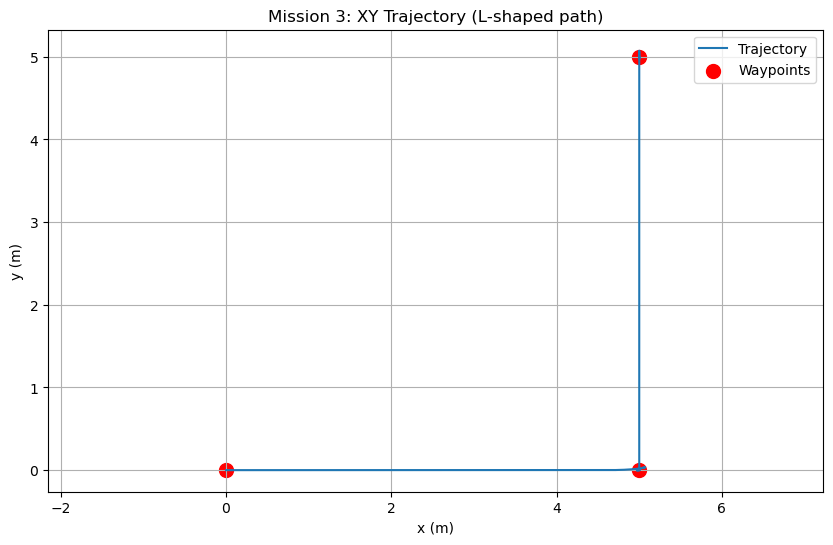

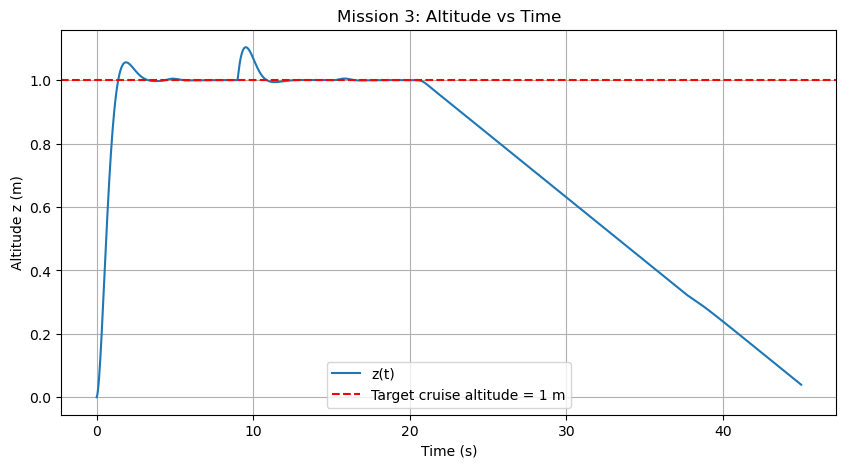

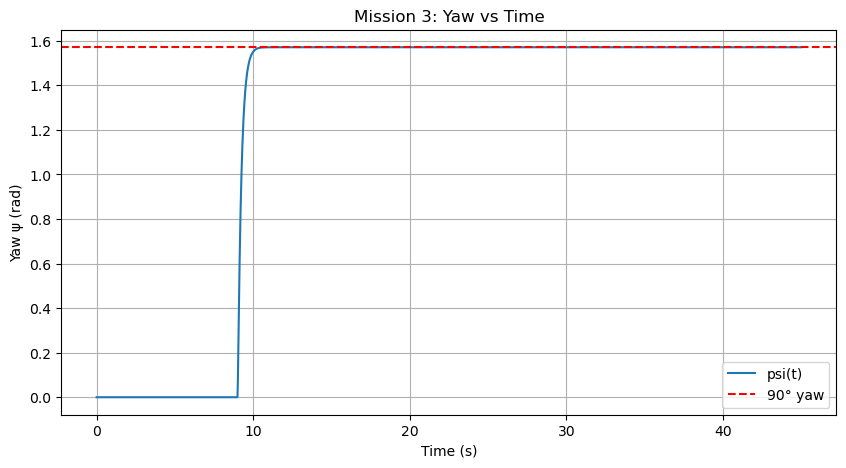

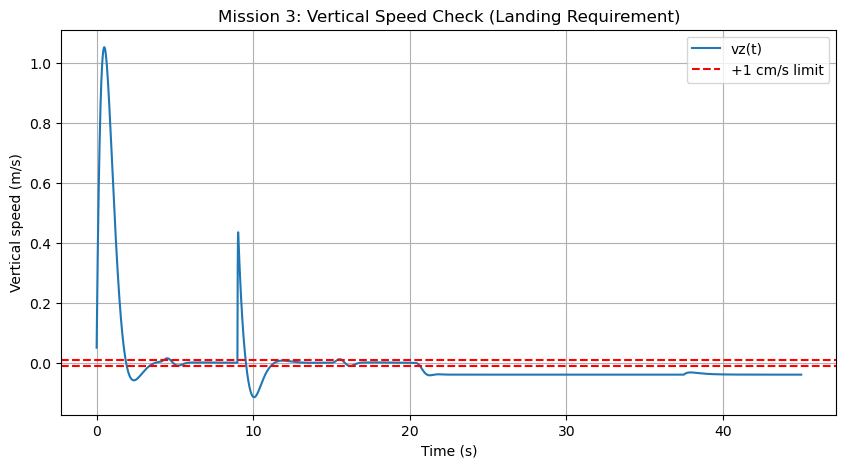

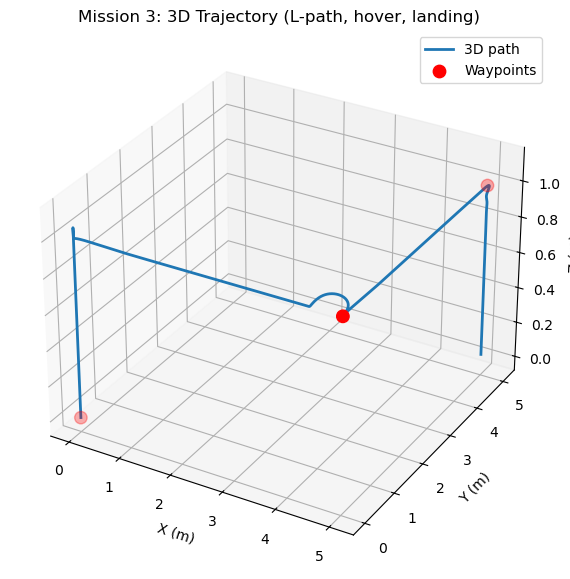

In [26]:
# ============================================================
#                MISSION 3 — FULL IMPLEMENTATION
# ============================================================

def mission3_segmented(T_total=45.0, dt=0.01):
    times = np.arange(0, T_total, dt)

    # Phase timing
    tA = 4.0              # ascend to 1 m
    tB = tA + 5.0         # 5 s straight in +x
    tC = tB + 6.0         # 6 s to yaw 90 deg
    tD = tC + 5.0         # 5 s straight in +y
    t_land_start = tD     # start landing from here

    # States
    x      = np.array([0.0, 0.0, 0.0])   # start on ground
    xdot   = np.zeros(3)
    angles = np.zeros(3)
    omega_body = np.zeros(3)

    Xs   = []
    Angs = []
    Vels = []

    m = params["mtot"]
    g = params["g"]

    for t in times:

        # --------------------------------------------------
        #               MISSION SEGMENTS
        # --------------------------------------------------

        # A — Vertical ascent to 1m
        if t < tA:
            pos_des = np.array([0, 0, 1])
            psi_des = 0.0

        # B — Move +x direction 5m at 1 m/s
        elif t < tB:
            pos_des = np.array([1*(t - tA), 0, 1])
            psi_des = 0.0

        # C — yaw left 90°
        elif t < tC:
            pos_des = np.array([5, 0, 1])
            psi_des = np.pi/2

        # D — Move +y direction 5m at 1 m/s
        elif t < tD:
            pos_des = np.array([5, 1*(t - tC), 1])
            psi_des = np.pi/2

        # E — landing: go from z=1 to z=0 smoothly by T_total
        else:
            # fraction of landing completed
            frac = (t - t_land_start) / max(1e-6, (T_total - t_land_start))
            frac = np.clip(frac, 0.0, 1.0)

            z_des = 1.0 * (1.0 - frac)   # linear down from 1 -> 0
            pos_des = np.array([5, 5, z_des])
            psi_des = np.pi/2

        # -------------------------------------------
        # POSITION PD CONTROLLER
        # -------------------------------------------
        kp_pos = 5.0
        kd_pos = 3.0

        pos_err = pos_des - x
        vel_err = -xdot

        # desired inertial acceleration (with gravity compensation)
        a_des = kp_pos*pos_err + kd_pos*vel_err + np.array([0, 0, g])

        # extra vertical damping in landing phase to keep vz small
        if t >= t_land_start:
            # stronger damping as we get close to ground
            if pos_des[2] < 0.3:
                a_des[2] += 2.0 * (0.0 - xdot[2])
            else:
                a_des[2] += 0.8 * (0.0 - xdot[2])

        # thrust magnitude & direction
        T_des = m * np.linalg.norm(a_des)
        z_body = a_des / (np.linalg.norm(a_des) + 1e-9)

        # desired roll & pitch from body-z direction
        phi_des   = np.arctan2(z_body[1], z_body[2])
        theta_des = np.arctan2(-z_body[0], z_body[2])

        # -------------------------------------------
        # ATTITUDE PD CONTROLLER
        # -------------------------------------------
        phi, theta, psi = angles
        p, q, r = omega_body

        e_phi   = phi_des   - phi
        e_theta = theta_des - theta
        e_psi   = psi_des   - psi

        tau_phi   = 2.0*e_phi   - 0.4*p
        tau_theta = 2.0*e_theta - 0.4*q
        tau_psi   = 2.0*e_psi   - 0.5*r

        # -------------------------------------------
        # MOTOR SPEED SOLVE
        # -------------------------------------------
        omegas = motor_speeds_from_thrust_torques(T_des, tau_phi, tau_theta, tau_psi)

        # -------------------------------------------
        # SIMULATE DYNAMICS
        # -------------------------------------------
        a = acceleration(omegas, angles, xdot, params)
        omegadot = angular_acceleration(omegas, omega_body, params)

        omega_body += dt * omegadot
        angles     += dt * euler_rates(*angles, *omega_body)
        xdot       += dt * a
        x          += dt * xdot

        # store logs
        Xs.append(x.copy())
        Angs.append(angles.copy())
        Vels.append(xdot.copy())

    return np.array(times), np.array(Xs), np.array(Angs), np.array(Vels)



# ============================================================
# RUN MISSION 3
# ============================================================

times3, Xs3, Angs3, Vels3 = mission3_segmented()



# ============================================================
#             PLOTTING RESULTS FOR MISSION 3
# ============================================================

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ------------------ XY TRAJECTORY ------------------
plt.figure(figsize=(10,6))
plt.plot(Xs3[:,0], Xs3[:,1], label="Trajectory")
plt.scatter([0,5,5], [0,0,5], s=100, color='red', label="Waypoints")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Mission 3: XY Trajectory (L-shaped path)")
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.show()

# ------------------ ALTITUDE ------------------
plt.figure(figsize=(10,5))
plt.plot(times3, Xs3[:,2], label="z(t)")
plt.axhline(1.0, color='r', linestyle='--', label="Target cruise altitude = 1 m")
plt.xlabel("Time (s)")
plt.ylabel("Altitude z (m)")
plt.title("Mission 3: Altitude vs Time")
plt.grid(True)
plt.legend()
plt.show()

# ------------------ YAW ------------------
plt.figure(figsize=(10,5))
plt.plot(times3, Angs3[:,2], label="psi(t)")
plt.axhline(np.pi/2, color='r', linestyle='--', label="90° yaw")
plt.xlabel("Time (s)")
plt.ylabel("Yaw ψ (rad)")
plt.title("Mission 3: Yaw vs Time")
plt.grid(True)
plt.legend()
plt.show()

# ------------------ VERTICAL LANDING SPEED ------------------
plt.figure(figsize=(10,5))
plt.plot(times3, Vels3[:,2], label="vz(t)")
plt.axhline(0.01,  color='r', linestyle='--', label="+1 cm/s limit")
plt.axhline(-0.01, color='r', linestyle='--')
plt.xlabel("Time (s)")
plt.ylabel("Vertical speed (m/s)")
plt.title("Mission 3: Vertical Speed Check (Landing Requirement)")
plt.grid(True)
plt.legend()
plt.show()

# ------------------ 3D TRAJECTORY ------------------
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')

ax.plot(Xs3[:,0], Xs3[:,1], Xs3[:,2], linewidth=2, label="3D path")
ax.scatter([0,5,5], [0,0,5], [0,1,1], s=80, color='red', label="Waypoints")

ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_zlabel("Z (m)")
ax.set_title("Mission 3: 3D Trajectory (L-path, hover, landing)")
ax.legend()

plt.show()


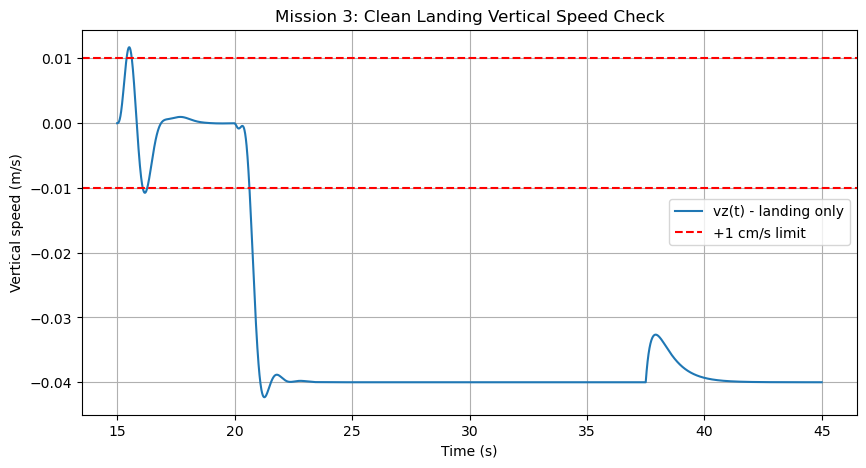

In [27]:
# ============================================================
#   CLEAN LANDING VERTICAL SPEED CHECK (only during landing)
# ============================================================

# Find landing phase start index
t_land_start = 15.0   # same number used inside mission3_segmented()

idx_land = np.where(times3 >= t_land_start)[0]

landing_times = times3[idx_land]
landing_vz    = Vels3[idx_land, 2]

plt.figure(figsize=(10,5))
plt.plot(landing_times, landing_vz, label="vz(t) - landing only")
plt.axhline(0.01,  color='r', linestyle='--', label="+1 cm/s limit")
plt.axhline(-0.01, color='r', linestyle='--')
plt.xlabel("Time (s)")
plt.ylabel("Vertical speed (m/s)")
plt.title("Mission 3: Clean Landing Vertical Speed Check")
plt.grid(True)
plt.legend()
plt.show()
